# Extended Trapping SINDy
By Alan Kaptanoglu

A very common issue is that models identified by system identification methods typically have no guarantees that the models are numerically or physically stable. This can be addressed with heuristic, data-driven, or analytic closure models, but we have recently directly promoted globally stable models into the system identification itself (see the Example 8 Jupyter notebook). This is really nice but there are three potential caveats, (1) the regression is nonconvex and there a number of hyperparameters, so this method can be difficult to learn, and (2) in order to promote global stability, one needs an analytic result from stability theory, and the one we use applies only for quadratically nonlinear dynamics (typically fluid and plasma flows) with energy-preserving, quadratic, nonlinearities. Moreover, we have now (3) additionally shown that generic quadratically nonlinear models will always be globally *unbounded*, so for these situations we can also promote local Lyapunov stability of the origin using some variations of the original Trapping SINDy algorithm. That is the goal of this notebook -- to illustrate how various forms of global and local stability can be promoted explicitly in the SINDy method to obtain stable data-driven models.

For the following, we will consider dynamical models of the form
$$\dot{x}_i = L_{ij}x_j + Q_{ijk}x_ix_jx_k.$$
For global stability promotion, we will require skew-symmetry in the quadratic coefficients
$$ Q_{ijk} + Q_{jik} + Q_{kij} = 0.$$
This equation will be implemented as a hard constraint in the optimization. However, for dynamical models that do not satisfy this condition, we can still promote locally stable models that are stable even at fairly large distances of the origin. The following examples show different ways to relax this hard constraint.

### Von Karman shedding behind circular cylinder, Re = 100
The example we will use to demonstrate the various stability-promotion techniques is the von Karman vortex street.
In many cases, the wake behind a bluff body is characterized by a periodic vortex shedding phenomenon known as a von Karman street.
The two-dimensional incompressible flow past a cylinder is a stereotypical example of such behavior.

The transient energy growth and saturation amplitude of this instability mode is of particular interest and has historically posed a significant modeling challenge.
Noack et al. (2003) used an 8-mode POD basis that was augmented with a ninth "shift mode" parameterizing a mean flow deformation. The 9-mode quadratic Galerkin model does resolve the transient dynamics, nonlinear stability mechanism, and post-transient oscillation, accurately reproducing all of the key physical features of the vortex street. In general, the skew-symmetry structure in the quadratic coefficients $Q_{ijk}$ is weakly *broken* in models for the von Karman street, but it can be enforced to hold exactly. 

This is precisely what is done in Schlegel and Noack (2015), and in this perfectly-skew-symmetric case, the global stability of the quadratic model was proven with $m_9 = m_\text{shift} = \epsilon$, $\epsilon > 1$, and $m_i = 0$ for $i = \{1,...,8\}$. Indeed, we do similarly for data-driven models obtained with the SINDy method in the Example 8 Jupyter notebook. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pysindy as ps 
from scipy.integrate import solve_ivp
import matplotlib.gridspec as gridspec
import scipy.io as sio

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('data/vonKarman_pod/')
import neksuite as nek
from scipy.interpolate import griddata

In [2]:
# Define some setup and plotting functions
# Build the skew-symmetric nonlinearity constraints
def make_constraints(r):
    q = 0
    N = int((r ** 2 + 3 * r) / 2.0)
    p = r + r * (r - 1) + int(r * (r - 1) * (r - 2) / 6.0)
    constraint_zeros = np.zeros(p)
    constraint_matrix = np.zeros((p, r * N))    
    
    # Set coefficients adorning terms like a_i^3 to zero
    for i in range(r):
        constraint_matrix[q, r * (N - r) + i * (r + 1)] = 1.0
        q = q + 1

    # Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[q, r * (r + j - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
            q = q + 1
    for i in range(r):
         for j in range(0, i):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[q, r * (r + i - 1) + j + r * int(j * (2 * r - j - 3) / 2.0)] = 1.0
            q = q + 1

    # Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            for k in range(j + 1, r):
                constraint_matrix[q, r * (r + k - 1) + i + r * int(j * (2 * r - j - 3) / 2.0)] = 1.0
                constraint_matrix[q, r * (r + k - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
                constraint_matrix[q, r * (r + j - 1) + k + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
                q = q + 1
                
    return constraint_zeros, constraint_matrix
    
    
# Use optimal m, and calculate eigenvalues(PW) to see if identified model is stable
def check_stability(r, Xi, mod_matrix, sindy_opt, mean_val):
    opt_m = sindy_opt.m_history_[-1]
    PL_tensor_unsym = sindy_opt.PL_unsym_
    PL_tensor = sindy_opt.PL_
    mPQ = -np.tensordot(
                sindy_opt.PQ_,
                opt_m, axes=([2], [0])
    ) - np.tensordot(
                np.transpose(sindy_opt.PQ_, [0, 2, 1, 3, 4]),
                opt_m, axes=([1], [0]),
    )
    mPQ = (mPQ + np.transpose(mPQ, [1, 0, 2, 3])) / 2.0
    P_tensor = PL_tensor - mPQ
    As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
    As = mod_matrix @ As
    eigvals, eigvecs = np.linalg.eigh(As)
    print('optimal m: ', opt_m)
    print('As eigvals: ', np.sort(eigvals))
    max_eigval = np.sort(eigvals)[-1]
    min_eigval = np.sort(eigvals)[0]
    L = np.tensordot(PL_tensor_unsym, Xi, axes=([3, 2], [0, 1]))
    Q = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
    d = np.dot(L, opt_m) + np.dot(np.tensordot(Q, opt_m, axes=([2], [0])), opt_m)
    d = mod_matrix @ d
    Rm = np.linalg.norm(d) / np.abs(max_eigval)
    Reff = Rm / mean_val
    print('Estimate of trapping region size, Rm = ', Rm)
    print('Normalized trapping region size, Reff = ', Reff)


# Plot first three modes in 3D for ground truth and SINDy prediction
def make_3d_plots(x_test, x_test_pred, filename):
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(8, 8))
    if filename == 'VonKarman':
        ind = -1
    else:
        ind = 2
    plt.plot(x_test[:, 0], x_test[:, 1], x_test[:, ind], 
             'r', label='true x')
    plt.plot(x_test_pred[:, 0], x_test_pred[:, 1], x_test_pred[:, ind], 
             'k', label='pred x')
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_axis_off()
    plt.legend(fontsize=14)
    plt.show()


# Plot the SINDy fits of X and Xdot against the ground truth
def make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, filename):
    fig = plt.figure(figsize=(16, 8))
    spec = gridspec.GridSpec(ncols=2, nrows=r, figure=fig, hspace=0.0, wspace=0.0)
    for i in range(r):
        plt.subplot(spec[i, 0]) #r, 2, 2 * i + 2)
        plt.plot(t, xdot_test[:, i], 'r', 
                 label=r'true $\dot{x}_' + str(i) + '$')
        plt.plot(t, xdot_test_pred[:, i], 'k--', 
                 label=r'pred $\dot{x}_' + str(i) + '$')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.legend(fontsize=12)
        if i == r - 1:
            plt.xlabel('t', fontsize=18)
        plt.subplot(spec[i, 1])
        plt.plot(t, x_test[:, i], 'r', label=r'true $x_' + str(i) + '$')
        plt.plot(t, x_test_pred[:, i], 'k--', label=r'pred $x_' + str(i) + '$')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.legend(fontsize=12)
        if i == r - 1:
            plt.xlabel('t', fontsize=18)
        
    plt.show()
    
    
# Plot errors between m_{k+1} and m_k and similarly for the model coefficients
def make_progress_plots(r, sindy_opt):
    W = np.asarray(sindy_opt.history_)
    M = np.asarray(sindy_opt.m_history_)
    dW = np.zeros(W.shape[0])
    dM = np.zeros(M.shape[0])
    for i in range(1,W.shape[0]):
        dW[i] = np.sum((W[i, :, :] - W[i - 1, :, :]) ** 2)
        dM[i] = np.sum((M[i, :] - M[i - 1, :]) ** 2)
    plt.figure()
    plt.semilogy(dW, label=r'Coefficient progress, $\|\xi_{k+1} - \xi_k\|_2^2$')
    plt.semilogy(dM, label=r'Vector m progress, $\|m_{k+1} - m_k\|_2^2$')
    plt.xlabel('Algorithm iterations', fontsize=16)
    plt.ylabel('Errors', fontsize=16)
    plt.legend(fontsize=14)
    PWeigs = np.asarray(sindy_opt.PWeigs_history_)
    plt.figure()
    for j in range(r):
        if np.all(PWeigs[:, j] > 0.0):
            plt.semilogy(PWeigs[:, j], 
                         label=r'diag($P\xi)_{' + str(j) + str(j) + '}$')
        else:
            plt.plot(PWeigs[:, j], 
                     label=r'diag($P\xi)_{' + str(j) + str(j) + '}$')
        plt.xlabel('Algorithm iterations', fontsize=16)
        plt.legend(fontsize=12)
        plt.ylabel(r'Eigenvalues of $P\xi$', fontsize=16)


# Make a bar plot of the distribution of SINDy coefficients
# and distribution of Galerkin coefficients for the von Karman street
def make_bar(galerkin9, L, Q, Lens, Qens):
    bins = np.logspace(-11, 0, 50)
    plt.figure(figsize=(8, 4))
    plt.grid('True')
    galerkin_full = np.vstack((galerkin9['L'].reshape(r ** 2, 1), 
                               galerkin9['Q'].reshape(len(galerkin9['Q'].flatten()), 1)))
    plt.hist(np.abs(galerkin_full), bins=bins, label='POD-9 model')
    sindy_full = np.vstack((L.reshape(r ** 2, 1), 
                            Q.reshape(len(galerkin9['Q'].flatten()), 1)))
    plt.hist(np.abs(sindy_full.flatten()), bins=bins, color='k', 
             label='Trapping SINDy model (energy)')
    sindy_full = np.vstack((Lens.reshape(r ** 2, 1), 
                            Qens.reshape(len(galerkin9['Q'].flatten()), 1)))
    plt.hist(np.abs(sindy_full.flatten()), bins=bins, color='r', 
             label='Trapping SINDy model (enstrophy)')
    plt.xscale('log')
    plt.legend(fontsize=14)
    ax = plt.gca()
    ax.set_axisbelow(True)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.set_yticks([0, 10, 20, 30])
    plt.xlabel('Coefficient values', fontsize=20)
    plt.ylabel('Number of coefficients', fontsize=20)
    plt.title('Histogram of coefficient values', fontsize=20)
    
    
# Helper function for reading and plotting the von Karman data
def get_velocity(file):
    global nel, nGLL
    field = nek.readnek(file)
    u = np.array([field.elem[i].vel[0, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])
    v = np.array([field.elem[i].vel[1, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])
    return u, v


# Helper function for reading and plotting the von Karman data
def get_vorticity(file):
    field = nek.readnek(file)
    vort = np.array([field.elem[i].temp[0, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])
    return vort


# Define von Karman grid
nx = 400
ny = 200
xmesh = np.linspace(-5, 15, nx)
ymesh = np.linspace(-5, 5, ny)
XX, YY = np.meshgrid(xmesh, ymesh)


# Helper function for plotting the von Karman data
def interp(field, method='cubic', 
           mask=(np.sqrt(XX ** 2 + YY ** 2) < 0.5).flatten('C')):
    global Cx, Cy, XX, YY
    """
    field - 1D array of cell values
    Cx, Cy - cell x-y values
    X, Y - meshgrid x-y values
    grid - if exists, should be an ngrid-dim logical that will be set to zer
    """
    ngrid = len(XX.flatten())
    grid_field = np.squeeze( np.reshape( griddata((Cx, Cy), field, (XX, YY), 
                                                  method=method), (ngrid, 1)) )
    if mask is not None:
        grid_field[mask] = 0
    return grid_field


# Helper function for plotting the von Karman data
def plot_field(field, clim=[-5, 5], label=None):
    """Plot cylinder field with masked circle"""
    im = plt.imshow(field, cmap='RdBu', vmin=clim[0], vmax=clim[1], 
                    origin='lower', extent=[-5, 15, -5, 5], 
                    interpolation='gaussian', label=label)
    cyl = plt.Circle((0, 0), 0.5, edgecolor='k', facecolor='gray')
    plt.gcf().gca().add_artist(cyl)
    return im


# Initialize quadratic SINDy library, with custom ordering 
# to be consistent with the constraint
library_functions = [lambda x:x, lambda x, y:x * y, lambda x:x ** 2]
library_function_names = [lambda x:x, lambda x, y:x + y, lambda x:x + x]
sindy_library = ps.CustomLibrary(library_functions=library_functions, 
                                 function_names=library_function_names)

# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-15
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-10

# Initialize a function for general quadratic Galerkin models
def galerkin_model(a, L, Q):
    """RHS of POD-Galerkin model, for time integration"""
    return (L @ a) + np.einsum('ijk,j,k->i', Q, a, a)

Great, so we defined a number of helper functions, and now we can load in the von Karman DNS data. For simplicity (and speed of the code), we will limit ourselves to 5D models, using the first 4 POD modes + the shift mode.

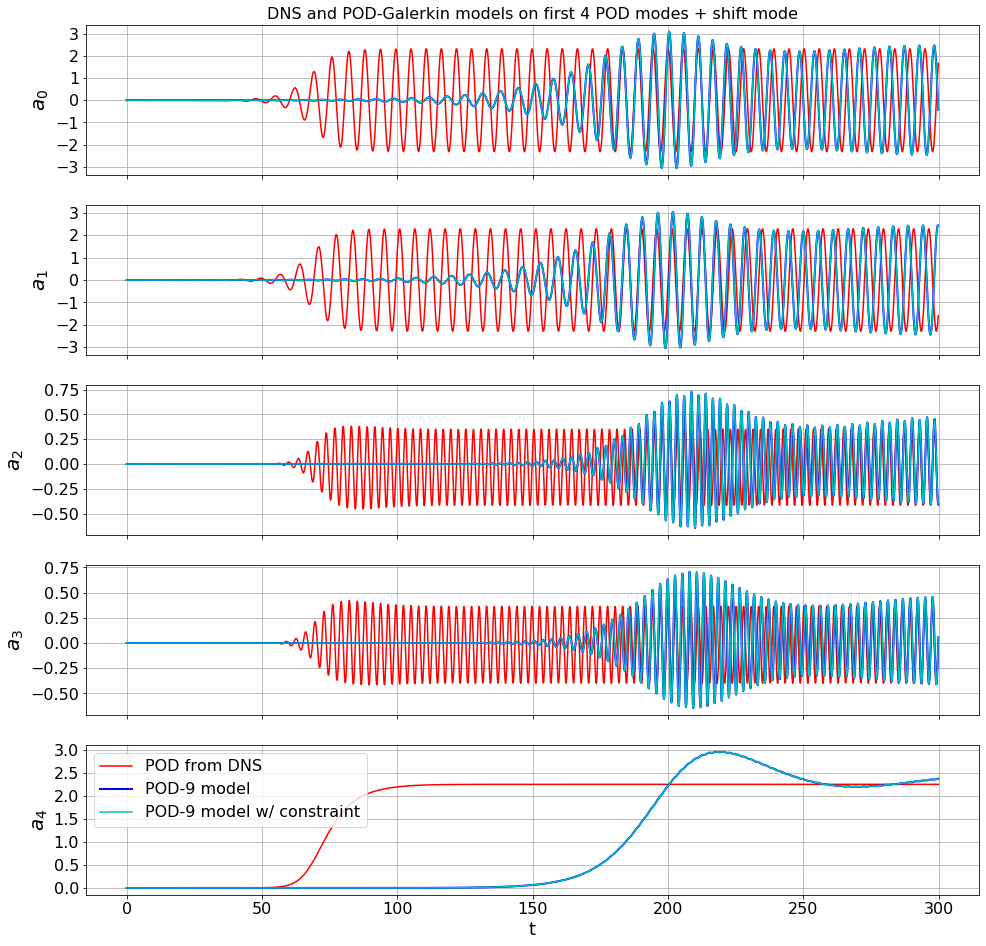

In [3]:
# define parameters and load in POD modes obtained from DNS
a = np.loadtxt('data/vonKarman_pod/vonKarman_a.dat')
t = a[:, 0]
r = 5
if r < 9:
    a_temp = a[:, 1:r]
    a_temp = np.hstack((a_temp, a[:, -1].reshape(3000, 1)))
    a = a_temp
else:
    a = a[:, 1:r + 1]

# optionally reduce the resolution slightly for more algorithm speed later
tbegin = 0
tend = 3000
skip = 1
t = t[tbegin:tend:skip]
a = a[tbegin:tend:skip, :]
dt = t[1] - t[0]

# define the POD-Galerkin models from Noack (2003)
galerkin9 = sio.loadmat('data/vonKarman_pod/galerkin9.mat')

# Build two Galerkin models, one in which the nonlinearity is as 
# calculated, and the other enforced to be exactly skew-symmetric.
gQ = 0.5 * (galerkin9['Q'] + np.transpose(galerkin9['Q'], [0, 2, 1]))
galerkin9['Q_ep'] = gQ - (gQ + np.transpose(gQ, [1, 0, 2]) + np.transpose(
    gQ, [2, 1, 0]) + np.transpose(
    gQ, [0, 2, 1]) + np.transpose(
    gQ, [2, 0, 1]) + np.transpose(
    gQ, [1, 2, 0])) / 6.0
model9 = lambda t, a: galerkin_model(a, galerkin9['L'], galerkin9['Q'])
model9_ep = lambda t, a: galerkin_model(a, galerkin9['L'], galerkin9['Q_ep'])

# Generate initial condition from unstable eigenvectors
# lamb, Phi = np.linalg.eig(galerkin9['L'])
# idx = np.argsort(-np.real(lamb))
# lamb, Phi = lamb[idx], Phi[:, idx]
a0 = np.zeros(5)
a0[0] = 1e-3
# np.real( 1e-3 * Phi[:, :2] @ np.random.random((2)) )

# get the 5D POD-Galerkin coefficients
inds5 = np.ix_([0, 1, 2, 3, -1], [0, 1, 2, 3, -1])
galerkin5 = {}
galerkin5['L'] = galerkin9['L'][inds5]
inds5 = np.ix_([0, 1, 2, 3, -1], [0, 1, 2, 3, -1], [0, 1, 2, 3, -1])
galerkin5['Q'] = galerkin9['Q'][inds5]
galerkin5['Q_ep'] = galerkin9['Q_ep'][inds5]
model5 = lambda t, a: galerkin_model(a, galerkin5['L'], galerkin5['Q'])
model5_ep = lambda t, a: galerkin_model(a, galerkin5['L'], galerkin5['Q_ep'])

# make the 5D POD-Galerkin model trajectories
t_span = (t[0], t[-1])
a_galerkin5 = solve_ivp(model5, t_span, a0, t_eval=t, 
                        **integrator_keywords).y.T
a_galerkin5_ep = solve_ivp(model5, t_span, a0, t_eval=t, 
                        **integrator_keywords).y.T
adot_galerkin5 = np.gradient(a_galerkin5, axis=0) / (t[1] - t[0])
adot_galerkin5_ep = np.gradient(a_galerkin5_ep, axis=0) / (t[1] - t[0])

# plot the first 4 POD modes + the shift mode
mode_numbers = range(10)
plt.figure(figsize=(16, 16))
for i in range(r):
    plt.subplot(r, 1, i + 1)
    if i == 0:
        plt.title('DNS and POD-Galerkin models on first 4 POD modes + shift mode', 
                  fontsize=16)
    plt.plot(t, a[:, mode_numbers[i]], 'r', label='POD from DNS')
    plt.plot(t, a_galerkin5[:, mode_numbers[i]], 'b', linewidth=2, label='POD-9 model')
    plt.plot(t, a_galerkin5_ep[:, mode_numbers[i]], 'c', label='POD-9 model w/ constraint')
    ax = plt.gca()
    plt.ylabel(r'$a_{' + str(mode_numbers[i]) + '}$', fontsize=20)
    plt.grid(True)
    if i == r - 1:
        plt.xlabel('t', fontsize=18)
        plt.legend(loc='upper left', fontsize=16)
    else:
        ax.set_xticklabels([])
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)

Note that the POD-9 models with and without the exact skew-symmetry constraints are functionally identical. The real differences will only emerge at significant distances from the origin of the state space. 

### Compute the velocity, vorticity, and enstrophy
The first thing we will do is promote globally stable models via the trapping SINDy algorithm, as in the Example 8 Jupyter notebook. We can actually do this by calculating a stability matrix $\mathbf{A}$ with *either* the energy or the enstrophy (or any other positive definite, quadratic quantity that plays an important role in the dynamics). So we begin by constructing globally stable trapping models of the von Karman street in these two ways.

First, we load in the data and compute the energy and enstrophy.

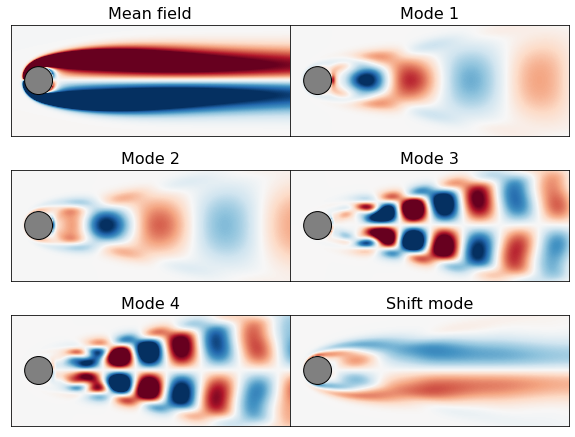

In [4]:
# path to POD mode files
field_path = 'data/vonKarman_pod/cyl0.snapshot'  
mode_path = 'data/vonKarman_pod/pod_modes/'  

# Read limit cycle flow field for grid points
field = nek.readnek(field_path)
nel = 2622  # Number of spectral elements
nGLL = 7  # Order of the spectral mesh
n = nel * nGLL ** 2

# define cell values needed for the vorticity interpolation
Cx = np.array([field.elem[i].pos[0, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])
Cy = np.array([field.elem[i].pos[1, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])

filename = lambda t_idx: 'cyl0.f{0:05d}'.format(t_idx)

# plot mean + leading POD modes
clim = [-1, 1]
file_order = [1, 2, 3, 4, 5, 10]
file_labels = ['Mean field', 
               'Mode 1', 'Mode 2', 'Mode 3', 'Mode 4',
               'Shift mode']

# Plot the vorticity fields as we load them in
fig = plt.figure(figsize=(10, 8))
spec = gridspec.GridSpec(ncols=2, nrows=3, figure=fig, hspace=0.0, wspace=0.0)
u_list = []
v_list = []
vorticities = []
vorticities_flat = []
for i in range(len(file_order)):
    plt.subplot(spec[i])
    u, v = get_velocity(mode_path + filename(file_order[i]))
    u_list.append(u)
    v_list.append(v)
    vort = interp( get_vorticity(mode_path + filename(file_order[i])) )
    vorticities.append(np.reshape(vort, [nx, ny], order='F').T)
    vorticities_flat.append(get_vorticity(mode_path + filename(file_order[i])))
    
    plot_field(np.reshape(vort, [nx, ny], order='F').T, clim=clim, 
               label=file_labels[i])
    plt.xlim([-1, 9])
    plt.ylim([-2, 2])
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title(file_labels[i], fontsize=16)

plt.show()

We have loaded in the vorticity fields of each POD mode, now need to calculate the  energy and the enstrophy.

In [5]:
mass_matrix = np.loadtxt('data/vonKarman_pod/pod_modes/mass_matrix.dat')
ip1 = lambda a, b: np.dot(mass_matrix * a, b)
ip2 = lambda a, b, c, d: np.dot(a * mass_matrix, c) + np.dot(b * mass_matrix, d)
energy_integrals = np.zeros((6, 6))
enstrophy_integrals = np.zeros((6, 6))
for i, wi in enumerate(vorticities_flat):
    for j, wj in enumerate(vorticities_flat):
        if i == 0:
            enstrophy_integrals[i, j] = ip2(u_list[i], v_list[i], wj, wj)
        else:
            enstrophy_integrals[i, j] = ip1(wi, wj)
        energy_integrals[i, j] = ip2(u_list[i], v_list[i], u_list[j], v_list[j])

Do some checks to make sure energy eigenvalues and enstrophy eigenvalues make sense (energy eigenvalues should be identitity because we are using the eigenbasis of energy, and enstrophy eigenvalues should be positive since enstrophy is by construction a positive definite quantity).

In [6]:
# Compute the energy eigenvalues 
P_energy = energy_integrals[1:, 1:]
eigs_energy, eigvecs_energy = np.linalg.eigh(P_energy)
print(eigs_energy)

# Compute the enstrophy eigenvalues 
P_enstrophy = enstrophy_integrals[1:, 1:]
eigs_enstrophy, eigvecs_enstrophy = np.linalg.eigh(P_enstrophy)
print(eigs_enstrophy)

# Define the linear part of the model, 
# rotated into the eigenbasis of enstrophy
L_enstrophy = np.dot(P_enstrophy, galerkin5['L'])

[1. 1. 1. 1. 1.]
[ 2.67263208  2.77593793  2.99681091 10.56822815 10.72500109]


### Check global stability of the POD-Galerkin models
Okay, so we have loaded in some DNS data from the von Karman Street and generated (analytic) 5D POD-Galerkin models for this system (without and without the skew-symmetric constraint). The skew-symmetric models below are globally stable *if and only if* there exists a vector $\mathbf{m}$ such that following matrix is negative definite:
$$A^S_{ij} = L^S_{ij} + (Q_{ijk} + Q_{jik})m_k.$$
Note that if the quadratic terms are skew-symmetric this is equal to
$$A^S_{ij} = L^S_{ij} - Q_{kij}m_k.$$
A negative definite $\mathbf{A}^S$ turns out to also be necessary for the non-skew-symmetric models, but in this case is not sufficient for global boundedness.

A good algorithm for a nonlinear search for a good $\mathbf{m}$ is simulated annealing, and a simple interface is provided by scipy. We show below that the models that are exactly skew-symmetric are globally stable, and the models that (weakly) break this constraint are not. This is true whether or not we consider the energy, enstrophy, or some other positive definite function!

In [32]:
# Import simulated annealing algorithm from scipy
from scipy.optimize import dual_annealing as anneal_algo

# define the objective function to be minimized by simulated annealing
def obj_function(m, L_obj, Q_obj, P_obj):
    mQ_full = np.tensordot(Q_obj, m, axes=([2], [0])) + np.tensordot(np.transpose(
                            Q_obj, axes=[1, 2, 0]), m, axes=([1], [0])
                        )
    mQ_full = (mQ_full + mQ_full.T) / 2.0
    As = L_obj + P_obj @ mQ_full
    eigvals, eigvecs = np.linalg.eigh(As)
    return(eigvals[-1])

# Search between -5000, 5000 for each component of m
boundvals = np.zeros((r, 2))
boundmax = 5000
boundmin = -5000
boundvals[:, 0] = boundmin
boundvals[:, 1] = boundmax

# run simulated annealing for a non-skew-symmetric
# model in the enstrophy eigenbasis,
# display optimal m, and print 
# the corresponding objective function value
Ls_enstrophy = 0.5 * (L_enstrophy + L_enstrophy.T)
algo_sol = anneal_algo(obj_function, bounds=boundvals, 
                       args=(Ls_enstrophy, galerkin5['Q'], P_enstrophy), 
                       maxiter=200)
opt_m = algo_sol.x
opt_energy = algo_sol.fun
opt_result = algo_sol.message
print('Non-skew-symmetric enstrophy model result:')
print('Optimal m = ', opt_m)
print('Algorithm managed to reduce the largest eigenvalue of A^S to eig1 = ', 
      opt_energy, '\n')

# Repeat for the skew-symmetric model in the enstrophy eigenbasis
algo_sol = anneal_algo(obj_function, bounds=boundvals, 
                       args=(Ls_enstrophy, galerkin5['Q_ep'], P_enstrophy), 
                       maxiter=200)
opt_m = algo_sol.x
opt_energy = algo_sol.fun
opt_result = algo_sol.message
print('Skew-symmetric enstrophy model result:')
print('Optimal m = ', opt_m)
print('Algorithm managed to reduce the largest eigenvalue of A^S to eig1 = ', 
      opt_energy, '\n')

# Repeat using the energy
Ls = 0.5 * (galerkin5['L'] + galerkin5['L'].T)
algo_sol = anneal_algo(obj_function, bounds=boundvals, 
                       args=(Ls, galerkin5['Q'], P_energy), 
                       maxiter=200)
opt_m = algo_sol.x
opt_energy = algo_sol.fun
opt_result = algo_sol.message
print('Non-skew-symmetric energy model result:')
print('Optimal m = ', opt_m)
print('Algorithm managed to reduce the largest eigenvalue of A^S to eig1 = ', 
      opt_energy, '\n')

# Repeat with skew-symmetric quadratic terms
algo_sol = anneal_algo(obj_function, bounds=boundvals, 
                       args=(Ls, galerkin5['Q_ep'], P_energy), 
                       maxiter=200)
opt_m = algo_sol.x
opt_energy = algo_sol.fun
opt_result = algo_sol.message
print('Skew-symmetric energy model result:')
print('Optimal m = ', opt_m)
print('Algorithm managed to reduce the largest eigenvalue of A^S to eig1 = ', 
      opt_energy)

Non-skew-symmetric enstrophy model result:
Optimal m =  [3.55186171e-01 4.81668397e-01 1.91073007e+01 8.56776760e+01
 5.00000000e+03]
Algorithm managed to reduce the largest eigenvalue of A^S to eig1 =  -2.8595428000088527 

Skew-symmetric enstrophy model result:
Optimal m =  [3.61574275e-01 5.21596448e-01 2.12921774e+01 8.95978610e+01
 5.00000000e+03]
Algorithm managed to reduce the largest eigenvalue of A^S to eig1 =  -0.5291486579704909 

Non-skew-symmetric energy model result:
Optimal m =  [ 2.85245533e-01 -2.22891600e-02  5.29925069e+01  2.72947908e+01
  5.00000000e+03]
Algorithm managed to reduce the largest eigenvalue of A^S to eig1 =  -0.6759003896435615 

Skew-symmetric energy model result:
Optimal m =  [ 2.10308091e-02 -1.23293452e-02  4.70550042e+00  2.75250110e+00
  4.39808901e+02]
Algorithm managed to reduce the largest eigenvalue of A^S to eig1 =  -0.043886355605302046


We have proven that both the models with skew-symmetric nonlinearities are globally stable. We now fix the coefficients of $\mathbf{m}$ except for the direction of the shift-mode, and scan this value to see how the largest eigenvalue of $\mathbf{A}^S$ (and corresponding trapping region radius) varies.

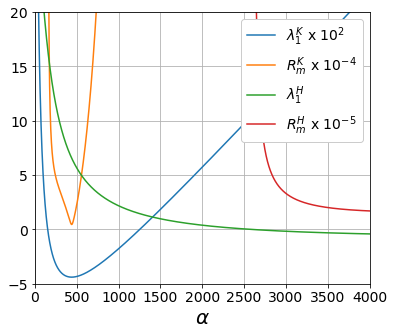

In [38]:
N = 5000
alphas = np.linspace(0, 4000, N)
m = np.zeros(r)
m[:-1] = [ 2.10308091e-02,
          -1.23293452e-02,  
          4.70550042e+00,  
          2.75250110e+00]
m_enstrophy = np.zeros(r)
m_enstrophy[:-1] = [3.61574275e-01,
                    5.21596448e-01,
                    2.12921774e+01,
                    8.95978610e+01]
obj_energy = np.zeros(N)
obj_enstrophy = np.zeros(N)
Rm_energy = np.zeros(N)
Rm_enstrophy = np.zeros(N)

# Extract maximum and minimum eigenvalues, 
# and compute radius of the trapping region
max_eig_energy = np.sort(eigs_energy)[-1]
max_eig_enstrophy = np.sort(eigs_enstrophy)[-1]

for i, alpha in enumerate(alphas):
    m[-1] = alpha
    m_enstrophy[-1] = alpha
    obj_energy[i] = obj_function(m, Ls, 
                                 galerkin5['Q_ep'], P_energy)
    obj_enstrophy[i] = obj_function(m_enstrophy, Ls_enstrophy, 
                                    galerkin5['Q_ep'], P_enstrophy)
    d_energy = np.dot(galerkin5['L'], m) + np.dot(
        np.tensordot(galerkin5['Q_ep'], m, axes=([2], [0])), m)
    d_enstrophy = np.dot(L_enstrophy, m_enstrophy) + np.dot(
        np.tensordot(galerkin5['Q_ep'], m_enstrophy, 
                     axes=([2], [0])), m_enstrophy)
    Rm_energy[i] = np.linalg.norm(d_energy) / np.abs(obj_energy[i])
    Rm_enstrophy[i] = np.linalg.norm(d_enstrophy) / np.abs(obj_enstrophy[i])

plt.figure(figsize=(6, 5))
plt.plot(alphas, obj_energy * 1e2, label='$\lambda_1^K$ x $10^2$')
plt.plot(alphas[obj_energy < 0], Rm_energy[obj_energy < 0] / 1.0e3, 
         label='$R_m^K$ x $10^{-4}$')
plt.plot(alphas, obj_enstrophy, label='$\lambda_1^H$')
plt.plot(alphas[obj_enstrophy < 0], Rm_enstrophy[obj_enstrophy < 0] / 1.0e5, 
         label='$R_m^H$ x $10^{-5}$')
plt.legend(fontsize=14, loc='upper right', framealpha=1.0)
plt.ylim(-5, 20)
plt.xlim(0, 4000)
plt.grid(True)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Data-driven 5D models for the von Karman street
We have investigated a number of 5D (analytic) POD-Galerkin models and shown that the skew-symmetric models are globally stable. Now we show that trapping SINDy can be used with the energy or enstrophy to build data-driven models that are also globally stable. 

We promote local Lyapunov stability further below. 

In [9]:
max_iter = 10
eta = 1.0
threshold = 0.1
alpha_m = 5e-1 * eta

# Initial guesses for m, A from longer run
m0 = [-0.07121953, -0.11870158, -0.0724682, -0.55328879, 3.1057168]

constraint_zeros, constraint_matrix = make_constraints(r)

# run trapping SINDy
sindy_opt = ps.TrappingSR3(
    threshold=threshold, eta=eta,
    alpha_m=alpha_m,
    max_iter=max_iter,
    m0=m0,
    constraint_lhs=constraint_matrix,
    constraint_rhs=constraint_zeros,
    constraint_order="feature",
    verbose=True,
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(a, t=t)
Xi = model.coefficients().T
PL_tensor = sindy_opt.PL_
PQ_tensor = sindy_opt.PQ_
Lenergy = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Qenergy = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
mean_val = np.mean(a, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, np.eye(r), sindy_opt, mean_val)
energy_model = model

3000 (3000, 5)
 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 1.978e+00 ... 3.495e-03 ... 9.82e-01 ... 7.95e-33 ... 2.39e-32 ... 2.96e+00
    1 ... 2.034e+00 ... 5.065e-03 ... 1.03e+00 ... -1.24e-31 ... -3.71e-31 ... 3.06e+00
    2 ... 2.049e+00 ... 4.985e-03 ... 1.03e+00 ... -1.71e-32 ... -5.13e-32 ... 3.08e+00
    3 ... 2.050e+00 ... 4.992e-03 ... 1.03e+00 ... 7.55e-32 ... 2.27e-31 ... 3.08e+00
    4 ... 2.052e+00 ... 4.971e-03 ... 1.03e+00 ... -2.40e-31 ... -7.21e-31 ... 3.09e+00
    5 ... 2.052e+00 ... 4.953e-03 ... 1.03e+00 ... -6.69e-31 ... -2.01e-30 ... 3.09e+00
    6 ... 2.054e+00 ... 4.935e-03 ... 1.03e+00 ... 2.72e-31 ... 8.15e-31 ... 3.09e+00
    7 ... 2.055e+00 ... 4.917e-03 ... 1.03e+00 ... 8.69e-32 ... 2.61e-31 ... 3.09e+00
    8 ... 2.056e+00 ... 4.899e-03 ... 1.03e+00 ... 3.54e-31 ... 1.06e-30 ... 3.09e+00
    9 ... 2.057e+00 ... 4.881e-03 ... 1.03e+00 ... 9.23e-32 ... 2.77e-31 ... 3.09e+00
optimal m:  [-0.00948685 -0.

/Users/alankaptanoglu/pysindy/pysindy/optimizers/trapping_sr3.py:926: ConvergenceWarning: TrappingSR3._reduce did not converge after 10 iters.
  ConvergenceWarning,


The previous model finds an $\mathbf{m}$ such that $\mathbf{A}^S$ is negative definite, while also fitting the data. Now we can repeat but in the eigenbasis of enstrophy. If the enstrophy is $H = \mathbf{y}^T\mathcal{P}\mathbf{A}^S \mathbf{y}$, now we are searching for an $\mathbf{m}$ such that $\mathcal{P}\mathbf{A}^S$ is negative definite.

In [25]:
max_iter = 5 
eta = 1.0e3 
threshold = 0.5
alpha_m = 0.5 * eta
m0 = [0.21952333, -0.13343907,  0.13482773, -0.2605744,   3.33325092]

mod_matrix = enstrophy_integrals[1:, 1:]
sindy_opt = ps.TrappingSR3(
    threshold=threshold, eta=eta, 
    alpha_m=alpha_m,
    m0=m0,
    max_iter=max_iter,
    constraint_lhs=constraint_matrix,
    constraint_rhs=constraint_zeros,
    constraint_order="feature",
    mod_matrix=mod_matrix,
    verbose=True,
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(a, t=t)
Xi = model.coefficients().T
Lenstrophy = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Qenstrophy = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
mean_val = np.mean(a, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, mod_matrix, sindy_opt, mean_val)
enstrophy_model = model

3000 (3000, 5)
 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 1.014e+00 ... 1.818e-06 ... 3.25e+00 ... 1.99e-30 ... 5.97e-30 ... 4.26e+00
    1 ... 1.013e+00 ... 2.041e-06 ... 3.24e+00 ... 1.71e-30 ... 5.14e-30 ... 4.25e+00
    2 ... 1.013e+00 ... 1.968e-06 ... 3.24e+00 ... 1.69e-30 ... 5.07e-30 ... 4.25e+00
    3 ... 1.013e+00 ... 1.959e-06 ... 3.24e+00 ... 1.69e-30 ... 5.07e-30 ... 4.25e+00
    4 ... 1.014e+00 ... 1.948e-06 ... 3.24e+00 ... 1.69e-30 ... 5.08e-30 ... 4.25e+00
optimal m:  [ 0.21919962 -0.13438546  0.13417209 -0.25857447  3.30908924]
As eigvals:  [-1.49789937 -0.39718349 -0.24858945 -0.21274521 -0.04349089]
Estimate of trapping region size, Rm =  103.76889224135414
Normalized trapping region size, Reff =  61.73203633669223


/Users/alankaptanoglu/pysindy/pysindy/optimizers/trapping_sr3.py:926: ConvergenceWarning: TrappingSR3._reduce did not converge after 5 iters.
  ConvergenceWarning,


Enstrophy model was successful!
#### Built 2 data-driven models with trapping SINDy, now we compare the distribution of coefficients in each model.

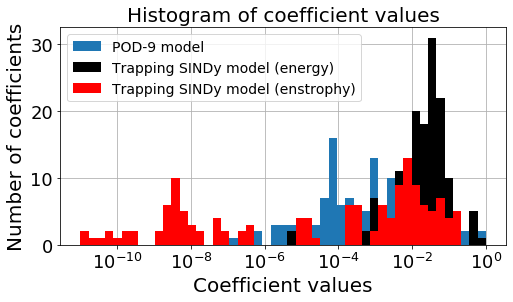

In [26]:
make_bar(galerkin5, Lenergy, Qenergy, Lenstrophy, Qenstrophy)

### Compare the models
Below, we compare the 5D POD-Galerkin with trapping SINDy models obtained by considering the energy or by the enstrophy. Both trapping models outperform the POD-Galerking model.

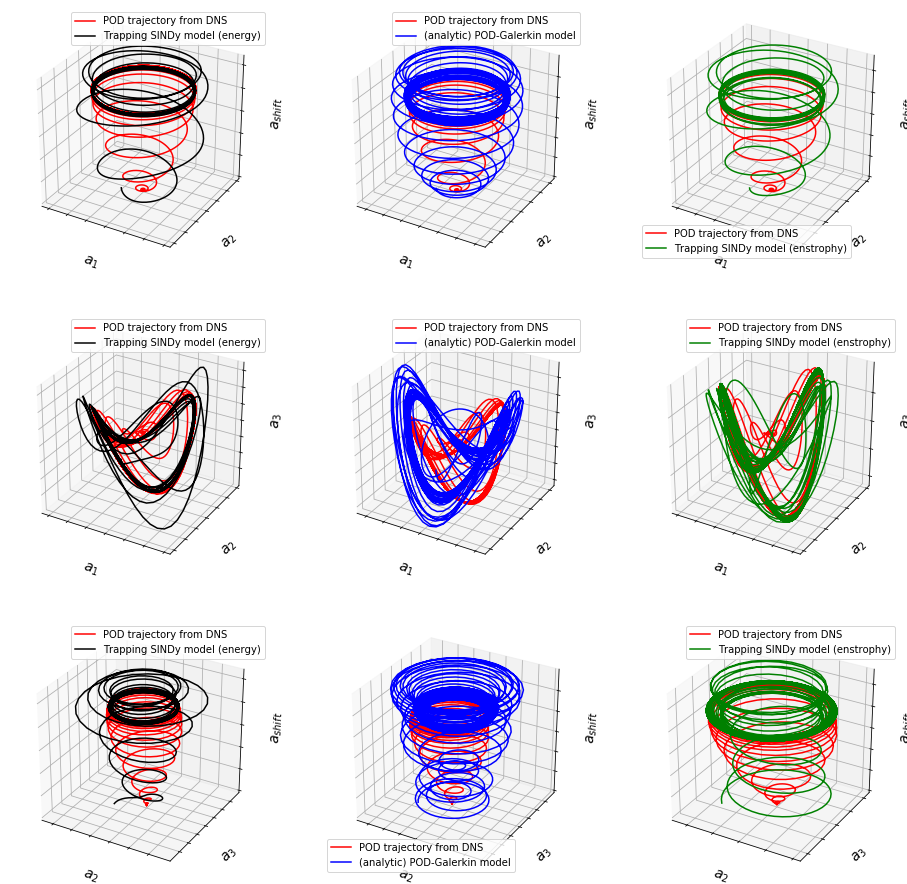

In [30]:
# Interpolate onto better time base
t_traj = np.linspace(t[0], t[-1], len(t) * 1)

# simulate trapping SINDy results
xtraj_energy = energy_model.simulate(a0, t_traj)
xtraj_enstrophy = enstrophy_model.simulate(a0, t_traj)

# simulate and plot 5D von Karman trajectory results
t_span = (t_traj[0], t_traj[-1])
xtraj_pod9 = solve_ivp(model5, t_span, a0, t_eval=t_traj, 
                       **integrator_keywords).y.T

# Make awesome plot
fig, ax = plt.subplots(3, 3, subplot_kw={'projection': '3d'}, figsize=(16, 16))
data = [x_test[:, [0, 1, -1]], xtraj_energy[:, [0, 1, -1]], 
        x_test[:, [0, 1, -1]], xtraj_pod9[:, [0, 1, -1]], 
        x_test[:, [0, 1, -1]], xtraj_enstrophy[:, [0, 1, -1]],
        x_test[:, [0, 1, 2]], xtraj_energy[:, [0, 1, 2]], 
        x_test[:, [0, 1, 2]], xtraj_pod9[:, [0, 1, 2]], 
        x_test[:, [0, 1, 2]], xtraj_enstrophy[:, [0, 1, 2]], 
        x_test[:, [2, 3, -1]], xtraj_energy[:, [2, 3, -1]], 
        x_test[:, [2, 3, -1]], xtraj_pod9[:, [2, 3, -1]],
        x_test[:, [2, 3, -1]], xtraj_enstrophy[:, [2, 3, -1]]]
data_labels = [[r'$a_1$', r'$a_2$', r'$a_{shift}$'], 
               [r'$a_1$', r'$a_2$', r'$a_3$'], 
               [r'$a_2$', r'$a_3$', r'$a_{shift}$']]
for i in range(3):
    ax[i, 0].plot(data[6 * i][:, 0], data[6 * i][:, 1], data[6 * i][:, 2], 
                  color='r', label='POD trajectory from DNS')
    ax[i, 0].plot(data[6 * i + 1][:, 0], data[6 * i + 1][:, 1], 
                  data[6 * i + 1][:, 2],
                  color='k', label='Trapping SINDy model (energy)')
    ax[i, 1].plot(data[6 * i + 2][:, 0], data[6 * i + 2][:, 1], 
                  data[6 * i + 2][:, 2],
                  color='r', label='POD trajectory from DNS')
    ax[i, 1].plot(data[6 * i + 3][:, 0], data[6 * i + 3][:, 1], 
                  data[6 * i + 3][:, 2],
                  color='b', label='(analytic) POD-Galerkin model')
    ax[i, 2].plot(data[6 * i + 4][:, 0], data[6 * i + 4][:, 1], 
                  data[6 * i + 4][:, 2],
                  color='r', label='POD trajectory from DNS')
    ax[i, 2].plot(data[6 * i + 5][:, 0], data[6 * i + 5][:, 1], 
                  data[6 * i + 5][:, 2],
                  color='g', label='Trapping SINDy model (enstrophy)')
    ax[i, 0].legend(fontsize=10)
    ax[i, 0].set_xticklabels([])
    ax[i, 0].set_yticklabels([])
    ax[i, 0].set_zticklabels([])
    ax[i, 0].set_xlabel(data_labels[i][0], fontsize=14)
    ax[i, 0].set_ylabel(data_labels[i][1], fontsize=14)
    ax[i, 0].set_zlabel(data_labels[i][2], fontsize=14)
    ax[i, 1].legend(fontsize=10)
    ax[i, 1].set_xticklabels([])
    ax[i, 1].set_yticklabels([])
    ax[i, 1].set_zticklabels([])
    ax[i, 1].set_xlabel(data_labels[i][0], fontsize=14)
    ax[i, 1].set_ylabel(data_labels[i][1], fontsize=14)
    ax[i, 1].set_zlabel(data_labels[i][2], fontsize=14)
    ax[i, 2].legend(fontsize=10)
    ax[i, 2].set_xticklabels([])
    ax[i, 2].set_yticklabels([])
    ax[i, 2].set_zticklabels([])
    ax[i, 2].set_xlabel(data_labels[i][0], fontsize=14)
    ax[i, 2].set_ylabel(data_labels[i][1], fontsize=14)
    ax[i, 2].set_zlabel(data_labels[i][2], fontsize=14)
plt.show()

### Promoting locally stable models with estimates of the stability radius
So far, we have promoted globally stable models with trapping SINDy by enforcing the skew-symmetry structure in the nonlinearities as a hard constraint in the optimization problem:

In [ ]:
from matplotlib import animation

# Define the full u(x, y, t) fields for the DNS, POD-Galerkin reconstruction
# and trapping SINDy reconstruction. 
u_true = np.zeros((vort.shape[0], a.shape[0]))
u_galerkin = np.zeros((vort.shape[0], a_galerkin9.shape[0]))
u_energy = np.zeros((vort.shape[0], a.shape[0]))
u_enstrophy = np.zeros((vort.shape[0], a.shape[0]))
n = 128478
r = 5
Psi = np.zeros([n, r])
Psi0 = get_vorticity(mode_path + filename(1))
for i in range(r - 1):
    Psi[:, i] = get_vorticity(mode_path + filename(i + 2))

Psi[:, -1] = get_vorticity(mode_path + filename(10))
    
# for reconstruction with the shift-mode
Psi0 = get_vorticity(mode_path + filename(1))
Psi_mean = np.outer(Psi0, np.ones(x_test.shape[0]))
u_true = Psi_mean + Psi @ x_test.T
u_energy = Psi_mean + Psi @ xtraj_energy.T
u_enstrophy = Psi_mean + Psi @ xtraj_enstrophy.T
Psi_mean = np.outer(Psi0, np.ones(a_galerkin5.shape[0]))
u_galerkin = Psi_mean + Psi @ a_galerkin5.T

# make the animation
fps = 30
fig = plt.figure(1, figsize=(16, 8) )
# plot DNS 
clim = [-3, 3]
tbegin = 400
tend = 2500
plt.subplot(2, 2, 1)
im1 = plot_field(np.reshape(interp(u_true[:, tbegin]), [nx, ny], order='F').T, 
                 clim=clim, label='DNS')
plt.xlim([-1, 9])
plt.ylim([-2, 2])
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
#ax.set_title('t = {0:.2f}'.format(t[tbegin]))
plt.xlabel('DNS', fontsize=18)
# plot POD-Galerkin reconstruction
plt.subplot(2, 2, 2)
im2 = plot_field(np.reshape(interp(u_galerkin[:, tbegin]), [nx, ny], order='F').T, 
                 clim=clim, label='POD-9')
plt.xlim([-1, 9])
plt.ylim([-2, 2])
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.xlabel('POD-5', fontsize=18)
# plot trapping SINDy reconstruction
plt.subplot(2, 2, 3)
im3 = plot_field(np.reshape(interp(u_energy[:, tbegin]), [nx, ny], order='F').T, 
                 clim=clim, label='Trapping SINDy (energy)')
plt.xlim([-1, 9])
plt.ylim([-2, 2])
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.xlabel('Trapping SINDy (energy)', fontsize=18)
plt.subplot(2, 2, 4)
im4 = plot_field(np.reshape(interp(u_enstrophy[:, tbegin]), [nx, ny], order='F').T, 
                 clim=clim, label='Trapping SINDy (enstrophy)')
plt.xlim([-1, 9])
plt.ylim([-2, 2])
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.xlabel('Trapping SINDy (enstrophy)', fontsize=18)
# switch back to subplot 1 
# plt.subplot(2, 2, 1)
# ax = plt.gca()


# animation function for looping through frames
def animate_func(i):
    if i % 100:
        print(i)
    plt.suptitle('t = {0:.2f}'.format(t[i]), fontsize=18)
    im1.set_array(np.reshape(interp(u_true[:, i]), [nx, ny], order='F').T)
    im2.set_array(np.reshape(interp(u_galerkin[:, i]), [nx, ny], order='F').T)
    im3.set_array(np.reshape(interp(u_energy[:, i]), [nx, ny], order='F').T)
    im4.set_array(np.reshape(interp(u_enstrophy[:, i]), [nx, ny], order='F').T)
    return [im1, im2, im3]


# anim = animation.FuncAnimation(fig, 
#                                animate_func, 
#                                frames = np.arange(tbegin, tend, 2),
#                                interval = 200)
# anim.save('vonKarman_meanfield.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])